# Lab:  Model Selection for Neural Data

Machine learning is a key tool for neuroscientists to understand how sensory and motor signals are encoded in the brain. In addition to improving our scientific understanding of neural phenomena, understanding neural encoding is critical for brain machine interfaces. In this lab, you will use linear regression with feature selection for performing some simple analysis on real neural signals.

Before doing this lab, you should review the ideas in the [polynomial model selection demo](./polyfit.ipynb).  In addition to the concepts in that demo, you will learn to:
* Load MATLAB data
* Formulate models of different complexities using heuristic model selection
* Fit a linear model for the different model orders (= # of features)
* Select the optimal features via cross-validation
  

## Loading the data

The data in this lab comes from neural recordings described in:

<a href="http://jn.physiology.org/content/106/2/764.short">
Stevenson, Ian H., et al. "Statistical assessment of the stability of neural movement representations." Journal of neurophysiology 106.2 (2011): 764-774</a>

Neurons are the basic information processing units in the brain.  Neurons communicate with one another via *spikes* or *action potentials* which are brief events where voltage in the neuron rapidly rises then falls.  These spikes trigger the electro-chemical signals between one neuron and another.  In this experiment, the spikes were recorded from 196 neurons in the primary motor cortex (M1) of a monkey using an electrode array implanted onto the surface of a monkey's brain.  During the recording, the monkey performed several reaching tasks and the position and velocity of the hand was recorded as well.  

The goal of the experiment is to try to *read the monkey's brain*:  That is, predict the hand position from the neural signals from the motor cortex.

We first load the basic packages.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

The full data is available on the CRCNS website  http://crcns.org/data-sets/movements/dream.  This website has a large number of great datasets and can be used for projects as well.  To make this lab easier, I have pre-processed the data slightly and placed it in the file `StevensonV2.mat`, which is a MATLAB file.  You will need to have this file downloaded in the directory you are working on.

Since MATLAB is widely-used, `python` provides method for loading MATLAB `mat` files.  We can use these commands to load the data as follows.

In [2]:
import scipy.io
from google.colab import files
uploaded = files.upload()
mat_dict = scipy.io.loadmat('/content/StevensonV2.mat')

Saving StevensonV2.mat to StevensonV2.mat


The returned structure, `mat_dict`, is a dictionary with each of the MATLAB variables that were saved in the `.mat` file.  Use the `.keys()` method to list all the variables.

In [3]:
print(mat_dict.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Publication', 'timeBase', 'spikes', 'time', 'handVel', 'handPos', 'target', 'startBins', 'targets', 'startBinned'])


We extract two variables, `spikes` and `handPos`, from the dictionary `mat_dict`, which represent the recorded spikes per neuron and the hand position.  We take the transpose of the spikes data so that it is in the form time bins $\times$ number of neurons.  For the `handPos` data, we take the second component which is the position of monkey's hand.

In [4]:
X0 = mat_dict['spikes'].T
y0 = mat_dict['handPos'][0,:]

The `spikes` matrix will be a `nt x nneuron` matrix where `nt` is the number of time bins and `nneuron` is the number of neurons.  Each entry `spikes[k,j]` is the number of spikes in time bin `k` from neuron `j`.  Use the `shape` method to find `nt` and `nneuron` and print the values.

In [5]:
# TODO
nt, nneuron = mat_dict['spikes'].shape #nt by nnueron matrix
print("nt # of time bins", nt)
print("# of neurons", nneuron)

nt # of time bins 196
# of neurons 15536


Now extract the `time` variable from the `mat_dict` dictionary.  Reshape this to a 1D array with `nt` components.  Each entry `time[k]` is the starting time of the time bin `k`.  Find the sampling time `tsamp` which is the time between measurements, and `ttotal` which is the total duration of the recording.

In [6]:
import numpy as np

time = mat_dict['time'].reshape(-1)
tsamp = time[1] - time[0]
ttotal = time[-1] - time[0]

print("Sampling time", tsamp)
print("Total duration of recording", ttotal)


Sampling time 0.049999999999998934
Total duration of recording 776.75


## Linear fitting on all the neurons

First divide the data into training and test with approximately half the samples in each.  Let `Xtr` and `ytr` denote the training data and `Xts` and `yts` denote the test data.

In [7]:
nt = X0.shape[0]  # Number of observations, not columns

split_point = nt // 2

Xtr = X0[:split_point, :]  # Training data: 1st half of the rows
ytr = y0[:split_point]     # Training labels: 1st half

Xts = X0[split_point:, :]  # Test data: 2nd half of the rows
yts = y0[split_point:]     # Test labels: 2nd half

print("Xtr", Xtr.shape, ", ytr", ytr.shape)
print("Xts", Xts.shape, ", yts", yts.shape)



Xtr (7768, 196) , ytr (7768,)
Xts (7768, 196) , yts (7768,)


Now, we begin by trying to fit a simple linear model using *all* the neurons as predictors.  To this end, use the `sklearn.linear_model` package to create a regression object, and fit the linear model to the training data.

In [8]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()

# Fit the model on training data
regressor.fit(Xtr, ytr)

print("Coefficients:", regressor.coef_)
print("Intercept:", regressor.intercept_)


Coefficients: [-8.12905437e-04  3.49818813e-03  3.82988601e-03  3.19318724e-03
  6.04677568e-04  2.78130263e-03 -3.62127256e-03  3.29975846e-03
 -2.45577005e-03  1.53326144e-03  3.55451654e-03  7.01880809e-03
  9.81737179e-04  1.46472203e+10  6.35374776e-04 -9.96901891e-05
  1.29698220e-03 -1.40748681e-02 -3.00193932e-03 -5.19882166e-03
 -1.98445368e-03 -2.96890783e-04  2.31904514e-03 -2.41394693e-04
  3.03855374e-02 -8.88102272e-04  1.40629672e-03  1.59608528e-04
 -1.23150120e-02  5.86400934e-04 -7.62708537e-04  5.70997771e-04
  1.92906618e-03  5.70192933e-05  6.81877136e-04 -1.12247467e-03
 -4.25815582e-04  1.44111812e-02  1.94811821e-03  3.17859650e-03
 -2.64252573e-02 -1.37782973e+10  2.52659619e-03  5.84125519e-04
 -1.07288361e-05  1.71518326e-03 -2.62467936e-03 -8.30173492e-04
 -2.44050324e-02 -1.04039013e-02 -2.86480784e-03 -7.47203827e-04
  2.17050314e-03 -3.35992873e-03  7.20441341e-04  3.03256512e-03
  3.03745270e-03  3.89850140e-03  7.84075260e-03  2.03990936e-03
  9.1954693

Measure and print the normalized RSS on the test data.  

In [11]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_pred = regressor.predict(Xts)

rss = np.sum((yts - y_pred) ** 2)

tss = np.sum((yts - np.mean(yts)) ** 2)
normalized_rss = rss / tss

print("Normalized RSS (test data)", normalized_rss)



Normalized RSS (test data) 4.1641540255669925e+20


You should see that the test error is enormous -- the model does not generalize to the test data at all.

## Linear Fitting  with Heuristic Model Selection

The above shows that we need a way to reduce the model complexity.  One simple idea is to select only the neurons that individually have a high correlation with the output.   

Write code which computes the coefficient of determination, $R^2_k$, for each neuron $k$.  Plot the $R^2_k$ values.  

You can use a for loop over each neuron, but if you want to make efficient code try to avoid the for loop and use [python broadcasting](../Basics/numpy_axes_broadcasting.ipynb).

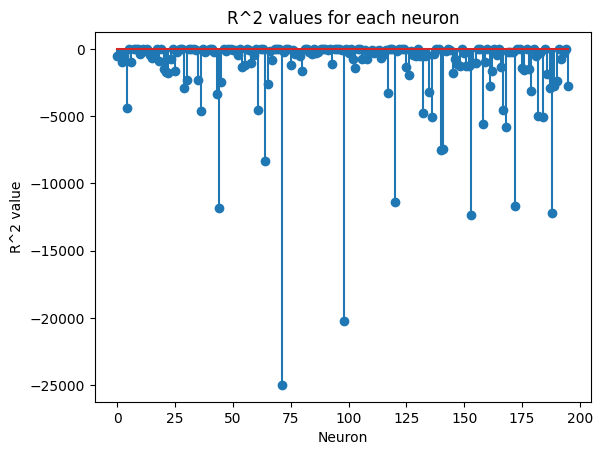

In [15]:
from sklearn.metrics import r2_score

Rsq = np.array([r2_score(ytr, Xtr[:, i]) for i in range(Xtr.shape[1])])

plt.stem(Rsq)
plt.xlabel("Neuron")
plt.ylabel("R^2 value")
plt.title("R^2 values for each neuron")
plt.show()

We see that many neurons have low correlation and can probably be discarded from the model.    

Use the `np.argsort()` command to find the indices of the `d=50` neurons with the highest $R^2_k$ value.  Put the `d` indices into an array `Isel`.  Print the indices of the neurons with the 10 highest correlations.

In [19]:
d = 50  # Number of neurons to use

Isel = np.argsort(Rsq)[-d:][::-1]
print("Indices of the neurons with the 10 highest correlations:", Isel[:10])


Indices of the neurons with the 10 highest correlations: [ 13  41 139 122 105 177  24  82  81  17]


Fit a model using only the `d` neurons selected in the previous step and print both the test RSS per sample and the normalized test RSS.

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


Xtr_sel = Xtr[:, Isel]
Xts_sel = Xts[:, Isel]

regressor_sel = LinearRegression()
regressor_sel.fit(Xtr_sel, ytr)

y_pred_sel = regressor_sel.predict(Xts_sel)

rss_per_sample = mean_squared_error(yts, y_pred_sel)

tss = np.sum((yts - np.mean(yts)) ** 2)
normalized_rss = rss_per_sample / tss

print("Test RSS per sample", rss_per_sample)
print("Normalized test RSS", normalized_rss)


Test RSS per sample 1.1288553073047728e+21
Normalized test RSS 7.47282719051887e+19


Create a scatter plot of the predicted vs. actual hand motion on the test data.  On the same plot, plot the line where `yts_hat = yts`.

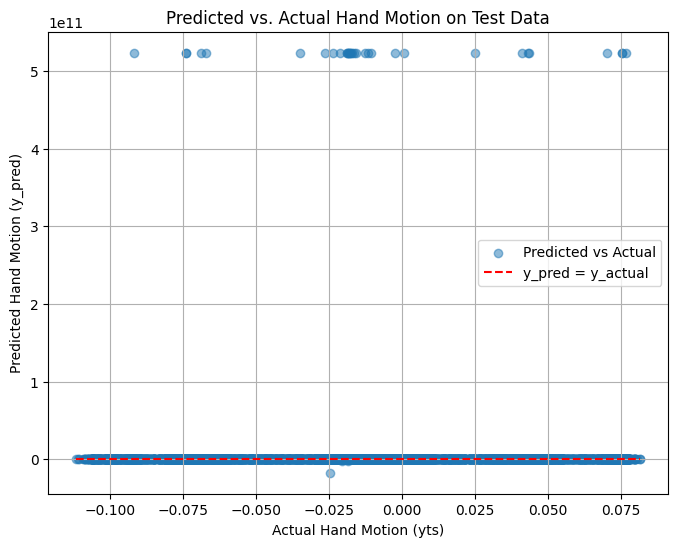

In [28]:

plt.figure(figsize=(8, 6))
plt.scatter(yts, y_pred_sel, alpha=0.5, label="Predicted vs Actual")

plt.plot([yts.min(), yts.max()], [yts.min(), yts.max()], 'r--', label="y_pred = y_actual")

plt.xlabel("Actual Hand Motion (yts)")
plt.ylabel("Predicted Hand Motion (y_pred)")
plt.title("Predicted vs. Actual Hand Motion on Test Data")
plt.legend()
plt.grid(True)
plt.show()

## Using K-fold cross validation for the optimal number of neurons

In the above, we fixed `d=50`.  We can use cross validation to try to determine the best number of neurons to use.  Try model orders with `d=10,20,...,190`.  For each value of `d`, use K-fold validation with 10 folds to estimate the test RSS.  For a data set this size, each fold will take a few seconds to compute, so it may be useful to print the progress.

Evaluating model with 10 neurons...
Test RSS for d=10: 1.352493496800527
Evaluating model with 20 neurons...
Test RSS for d=20: 1.3563267549385156
Evaluating model with 30 neurons...
Test RSS for d=30: 7.275993070822429e+22
Evaluating model with 40 neurons...
Test RSS for d=40: 1.1513841609147012e+21
Evaluating model with 50 neurons...
Test RSS for d=50: 7.81539103750334e+17
Evaluating model with 60 neurons...
Test RSS for d=60: 7.997230021132711e+18
Evaluating model with 70 neurons...
Test RSS for d=70: 7.496627889957054e+18
Evaluating model with 80 neurons...
Test RSS for d=80: 1.5911983093801437e+17
Evaluating model with 90 neurons...
Test RSS for d=90: 1.5588025074808206e+20
Evaluating model with 100 neurons...
Test RSS for d=100: 6.6428887700544774e+19
Evaluating model with 110 neurons...
Test RSS for d=110: 1.0553129803039423e+20
Evaluating model with 120 neurons...
Test RSS for d=120: 1.2179743027839074e+19
Evaluating model with 130 neurons...
Test RSS for d=130: 1.7381169438639

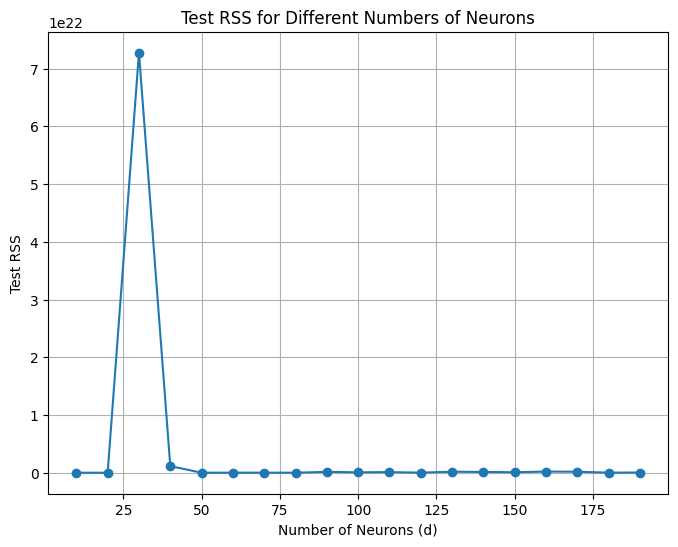

In [36]:
import numpy as np
import sklearn.model_selection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Create a k-fold object
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# Model orders to be tested
dtest = np.arange(10,200,10)
nd = len(dtest)

test_rss = np.zeros(nd)

# Loop over each value of d
for idx, d in enumerate(dtest):
    print(f"Evaluating model with {d} neurons...")

    Isel = np.argsort(Rsq)[-d:][::-1]
    Xtr_sel = Xtr[:, Isel]

    fold_rss = []

    for train_index, val_index in kf.split(Xtr_sel):

        X_train, X_val = Xtr_sel[train_index], Xtr_sel[val_index]
        y_train, y_val = ytr[train_index], ytr[val_index]

        regressor = LinearRegression()
        regressor.fit(X_train, y_train)

        y_pred_val = regressor.predict(X_val)

        rss_val = np.sum((y_val - y_pred_val) ** 2)
        fold_rss.append(rss_val)

    test_rss[idx] = np.mean(fold_rss)

    print(f"Test RSS for d={d}: {test_rss[idx]}")

optimal_d = dtest[np.argmin(test_rss)]
print(f"Optimal number of neurons: {optimal_d}")

plt.figure(figsize=(8, 6))
plt.plot(dtest, test_rss, marker='o')
plt.xlabel('Number of Neurons (d)')
plt.ylabel('Test RSS')
plt.title('Test RSS for Different Numbers of Neurons')
plt.grid(True)
plt.show()


Compute the RSS test mean and standard error and plot them as a function of the model order `d` using the `plt.errorbar()` method.

Mean RSS for d=190: 3.5963565293210796e+19
Standard Error for d=190: 2.846422759768105e+19


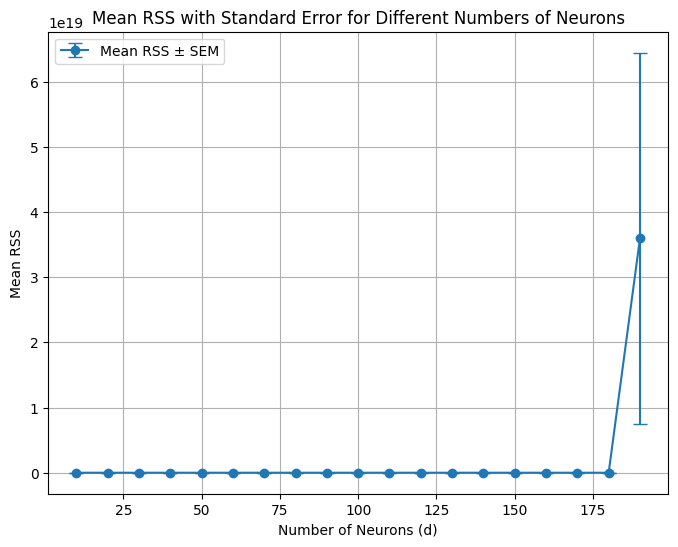

In [38]:
    import numpy as np
    import sklearn.model_selection
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    import matplotlib.pyplot as plt

    mean_rss = np.zeros(nd)
    std_err_rss = np.zeros(nd)

    mean_rss[idx] = np.mean(fold_rss)
    std_err_rss[idx] = np.std(fold_rss) / np.sqrt(nfold)

    print(f"Mean RSS for d={d}: {mean_rss[idx]}")
    print(f"Standard Error for d={d}: {std_err_rss[idx]}")

    # Plot mean RSS with error bars (standard error)
    plt.figure(figsize=(8, 6))
    plt.errorbar(dtest, mean_rss, yerr=std_err_rss, fmt='o', linestyle='-', capsize=5, label='Mean RSS ± SEM')
    plt.xlabel('Number of Neurons (d)')
    plt.ylabel('Mean RSS')
    plt.title('Mean RSS with Standard Error for Different Numbers of Neurons')
    plt.grid(True)
    plt.legend()
    plt.show()

Find the optimal order using the one standard error rule. Print the optimal value of `d` and the mean test RSS per sample at the optimal `d`.  

In [40]:

min_rss = np.min(mean_rss)
one_std_err_rule_rss = min_rss + std_err_rss[np.argmin(mean_rss)]

optimal_d_idx = np.argmax(mean_rss <= one_std_err_rule_rss)
optimal_d = dtest[optimal_d_idx]
optimal_rss = mean_rss[optimal_d_idx]

print(f"Optimal number of neurons (d): {optimal_d}")
print(f"Mean test RSS per sample at the optimal d: {optimal_rss}")

Optimal number of neurons (d): 10
Mean test RSS per sample at the optimal d: 0.0


## More Fun

You can play around with this and many other neural data sets.  Two things that one can do to further improve the quality of fit are:
* Use more time lags in the data.  Instead of predicting the hand motion from the spikes in the previous time, use the spikes in the last few delays.
* Add a nonlinearity.  You should see that the predicted hand motion differs from the actual for high values of the actual.  You can improve the fit by adding a nonlinearity on the output.  A polynomial fit would work well here.

You do not need to do these, but you can try them if you like.